In [ ]:
# Module: python3/3.11.7 
# Environment base: /g/data/xe2/datasets/Environments/paddockenv3_11
# Not using geospatenv because it doesn't have pysheds installed

In [1]:
# Standard library
import os
import pickle

# Dependencies
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from dea_tools.plotting import rgb

# Local imports
os.chdir(os.path.join(os.path.expanduser('~'), "Projects/PaddockTS"))
from DAESIM_preprocess.util import gdata_dir, scratch_dir, visualise_tif_rioxarray, plot_time_series, plot_time_point
from DAESIM_preprocess.topography import show_acc, show_aspect, show_slope, show_ridge_gullies, pysheds_accumulation, catchment_gullies, catchment_ridges, calculate_slope
from DAESIM_preprocess.canopy_height import visualise_canopy_height
from DAESIM_preprocess.sentinel import available_imagery_sentinel, calendar_plot_sentinel, time_lapse

In [2]:
stubs = {
    "MULL": "Mulloon",
    "CRGM": "Craig Moritz Farm",
    "MILG": "Milgadara",
    "ARBO": "Arboreturm",
    "KOWN": "Kowen Forest",
    "ADAM": "Canowindra"
}

In [3]:
# Filepaths
outdir = os.path.join(gdata_dir, "Data/PadSeg/")
visuals_dir = os.path.join(scratch_dir, "Visuals")
stub = "MULL"

In [4]:
%%time
# Calculate the terrain data
filename = os.path.join(outdir, f"{stub}_terrain.tif")
grid, dem, fdir, acc = pysheds_accumulation(filename)
num_catchments = 20
gullies, full_branches = catchment_gullies(grid, fdir, acc, num_catchments)
ridges = catchment_ridges(grid, fdir, acc, full_branches)
slope = calculate_slope(filename)

CPU times: user 20.5 s, sys: 9.86 s, total: 30.3 s
Wall time: 25.2 s


In [4]:
# Soils

# # Paddock boundaries
# filename = os.path.join(outdir, f"{stub}_segment.tif")
# ds = rxr.open_rasterio(filename)
# ds.plot()

# False colour NDWI fourier transform
# filename = os.path.join(outdir, f"{stub}.tif")
# ds = rxr.open_rasterio(filename)
# rgb_array = ds.transpose('y', 'x', 'band') / 255.0
# plt.imshow(rgb_array)

# NDVI calendar plot and paddock heatmap
# Fractional cover calendar plot and paddock heatmap
# Property boundaries

In [ ]:
%%time
# Topography
show_ridge_gullies(dem, ridges, gullies)

# Accumulation
show_acc(acc)

# Aspect
show_aspect(fdir)

# Slope
show_slope(slope) 

# Canopy Height
filename = os.path.join(outdir, f"{stub}_canopy_height.tif")
visualise_canopy_height(filename)

In [24]:
# Load the sentinel imagery
filename = os.path.join(outdir, f"{stub}_ds2.pkl")
with open(filename, 'rb') as file:
    ds = pickle.load(file)

In [25]:
ds

<xarray.Dataset>
Dimensions:                     (time: 193, y: 1047, x: 966)
Coordinates:
  * time                        (time) datetime64[ns] 2017-02-04T00:06:22.464...
  * y                           (y) float64 -4.22e+06 -4.22e+06 ... -4.23e+06
  * x                           (x) float64 1.443e+07 1.443e+07 ... 1.444e+07
    spatial_ref                 int32 6933
Data variables: (12/30)
    nbart_coastal_aerosol       (time, y, x) float32 214.0 214.0 ... 437.0 437.0
    nbart_blue                  (time, y, x) float32 242.0 186.0 ... 562.0 570.0
    nbart_green                 (time, y, x) float32 353.0 288.0 ... 881.0 865.0
    nbart_red                   (time, y, x) float32 369.0 311.0 ... 1.234e+03
    nbart_red_edge_1            (time, y, x) float32 647.0 647.0 ... 1.609e+03
    nbart_red_edge_2            (time, y, x) float32 1.553e+03 ... 2.202e+03
    ...                          ...
    oa_s2cloudless_prob         (time, y, x) float32 0.008117 ... 0.0985
    oa_nbart_contiguity         (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    oa_s2cloudless_mask         (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    NDVI                        (time, y, x) float32 0.7342 0.7388 ... 0.3605
    LAI                         (time, y, x) float32 1.322 1.151 ... 0.6806
    SAVI                        (time, y, x) float32 0.3933 0.3575 ... 0.2355
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [3]:
# Available imagery
available_imagery_sentinel(ds)

# Calendar plot thumbnail
calendar_plot_sentinel(ds)

# Calendar plot detailed
calendar_plot_sentinel(ds, size=5)

# Video
time_lapse(ds)

In [10]:
# Climate
filename = os.path.join(outdir, f"{stub}_ozwald_8day.nc")
ds_ozwald = xr.open_dataset(filename)

filename = os.path.join(outdir, f"{stub}_silo_daily.nc")
ds_silo = xr.open_dataset(filename)

In [107]:
# Find the maximum and minimum soil moisture to see some variation
ssoil_sum = ds_ozwald['Ssoil'].sum(dim='time')

max_row = int(ssoil_sum.argmax() // ssoil_sum.shape[0])
max_col = int(ssoil_sum.argmax() % ssoil_sum.shape[0])
min_row = int(ssoil_sum.argmin() // ssoil_sum.shape[0])
min_col = int(ssoil_sum.argmin() % ssoil_sum.shape[0])

ssoil_maxpoint = ds_ozwald.isel(longitude=max_row, latitude=max_col)
ssoil_minpoint = ds_ozwald.isel(longitude=min_row, latitude=min_col)

ssoil_maxpoint = ssoil_maxpoint.rename({'Ssoil': 'Maximum Soil Moisture'})
ssoil_minpoint = ssoil_minpoint.rename({'Ssoil': 'Minimum Soil Moisture'})

In [14]:
# Making the assumption that the four 5km SILO pixels are similar, so just choosing the first one. Later will want to be more precise using ANU Climate at 1km resolution. 
ds_silo_point = ds_silo.isel(lat=0, lon=0)

In [113]:
# Combine the datasets along the time dimension
ds_merged = xr.merge([ds_silo_point, ssoil_maxpoint, ssoil_minpoint], compat='override')
df = ds_merged.to_dataframe().reset_index()
df = df.drop(columns=["lat", "lon", "crs", "latitude", "longitude"])
df = df.set_index('time')

# # Rename the columns to match Alex's DAESim_forcing.csv
abbreviations = {
    "daily_rain" : "Rainfall",
    "max_temp" : "Maximum temperature",
    "min_temp" : "Minimum temperature",
    "et_morton_actual": "Actual Evapotranspiration",
    "et_morton_potential":"Potential Evapotranspiration"
    }
df.rename(columns=abbreviations, inplace=True)
df.rename_axis("date", inplace=True)
df

,Rainfall,Maximum temperature,Minimum temperature,Actual Evapotranspiration,Potential Evapotranspiration,Maximum Soil Moisture,Minimum Soil Moisture
date,,,,,,,
2017-01-01,0.000000,26.200001,14.600000,2.3,4.7,666.571472,106.431732
2017-01-02,0.099854,24.500000,14.100000,3.7,5.8,NaN,NaN
2017-01-03,0.000000,22.300001,10.900001,5.4,7.6,NaN,NaN
2017-01-04,0.099854,21.300001,11.400001,3.1,4.5,NaN,NaN
2017-01-05,0.300049,26.500000,9.500000,4.7,6.0,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-15,0.599854,17.100000,5.600000,2.2,2.3,NaN,NaN
2024-08-16,0.099854,16.000000,5.200000,1.8,1.8,NaN,NaN
2024-08-17,1.699951,12.100000,4.200000,1.2,1.7,NaN,NaN


In [134]:
weekly_df = df.resample('W').agg({
    "Rainfall":"sum",
    "Maximum temperature": "mean",
    "Minimum temperature": "mean",
    "Maximum Soil Moisture": "mean",
    "Minimum Soil Moisture": "mean",
    "Actual Evapotranspiration": "sum",
    "Potential Evapotranspiration": "sum"
})
weekly_df = weekly_df.interpolate('linear')

# We don't have soil moisture data for 2024 right now
weekly_df['Maximum Soil Moisture'][weekly_df.index > '2024-01-01'] = np.nan
weekly_df['Minimum Soil Moisture'][weekly_df.index > '2024-01-01'] = np.nan

weekly_df

/jobfs/123671020.gadi-pbs/ipykernel_996455/3658396061.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  weekly_df['Maximum Soil Moisture'][weekly_df.index > '2024-01-01'] = np.nan
/jobfs/123671020.gadi-pbs/ipykernel_996455/3658396061.py:1

,Rainfall,Maximum temperature,Minimum temperature,Maximum Soil Moisture,Minimum Soil Moisture,Actual Evapotranspiration,Potential Evapotranspiration
date,,,,,,,
2017-01-01,0.000000,26.200001,14.600000,666.571472,106.431732,2.300000,4.700000
2017-01-08,1.499756,25.842859,11.742858,663.330566,104.677811,33.100002,46.599998
2017-01-15,2.399658,31.585714,15.528572,660.089600,102.923882,28.400002,59.000000
2017-01-22,4.899658,29.657145,12.571428,657.241821,101.238159,23.000000,53.300003
2017-01-29,5.999756,30.628572,13.614286,655.877991,100.656342,25.300001,50.800003
...,...,...,...,...,...,...,...
2024-07-28,2.599854,12.514285,-0.214286,NaN,NaN,6.500000,12.700001
2024-08-04,0.099854,11.000000,-2.885714,NaN,NaN,7.800000,13.400001
2024-08-11,0.199707,13.728572,-1.028571,NaN,NaN,8.500000,14.100000


/scratch/xe2/cb8590/Visuals/MULL_weather.png


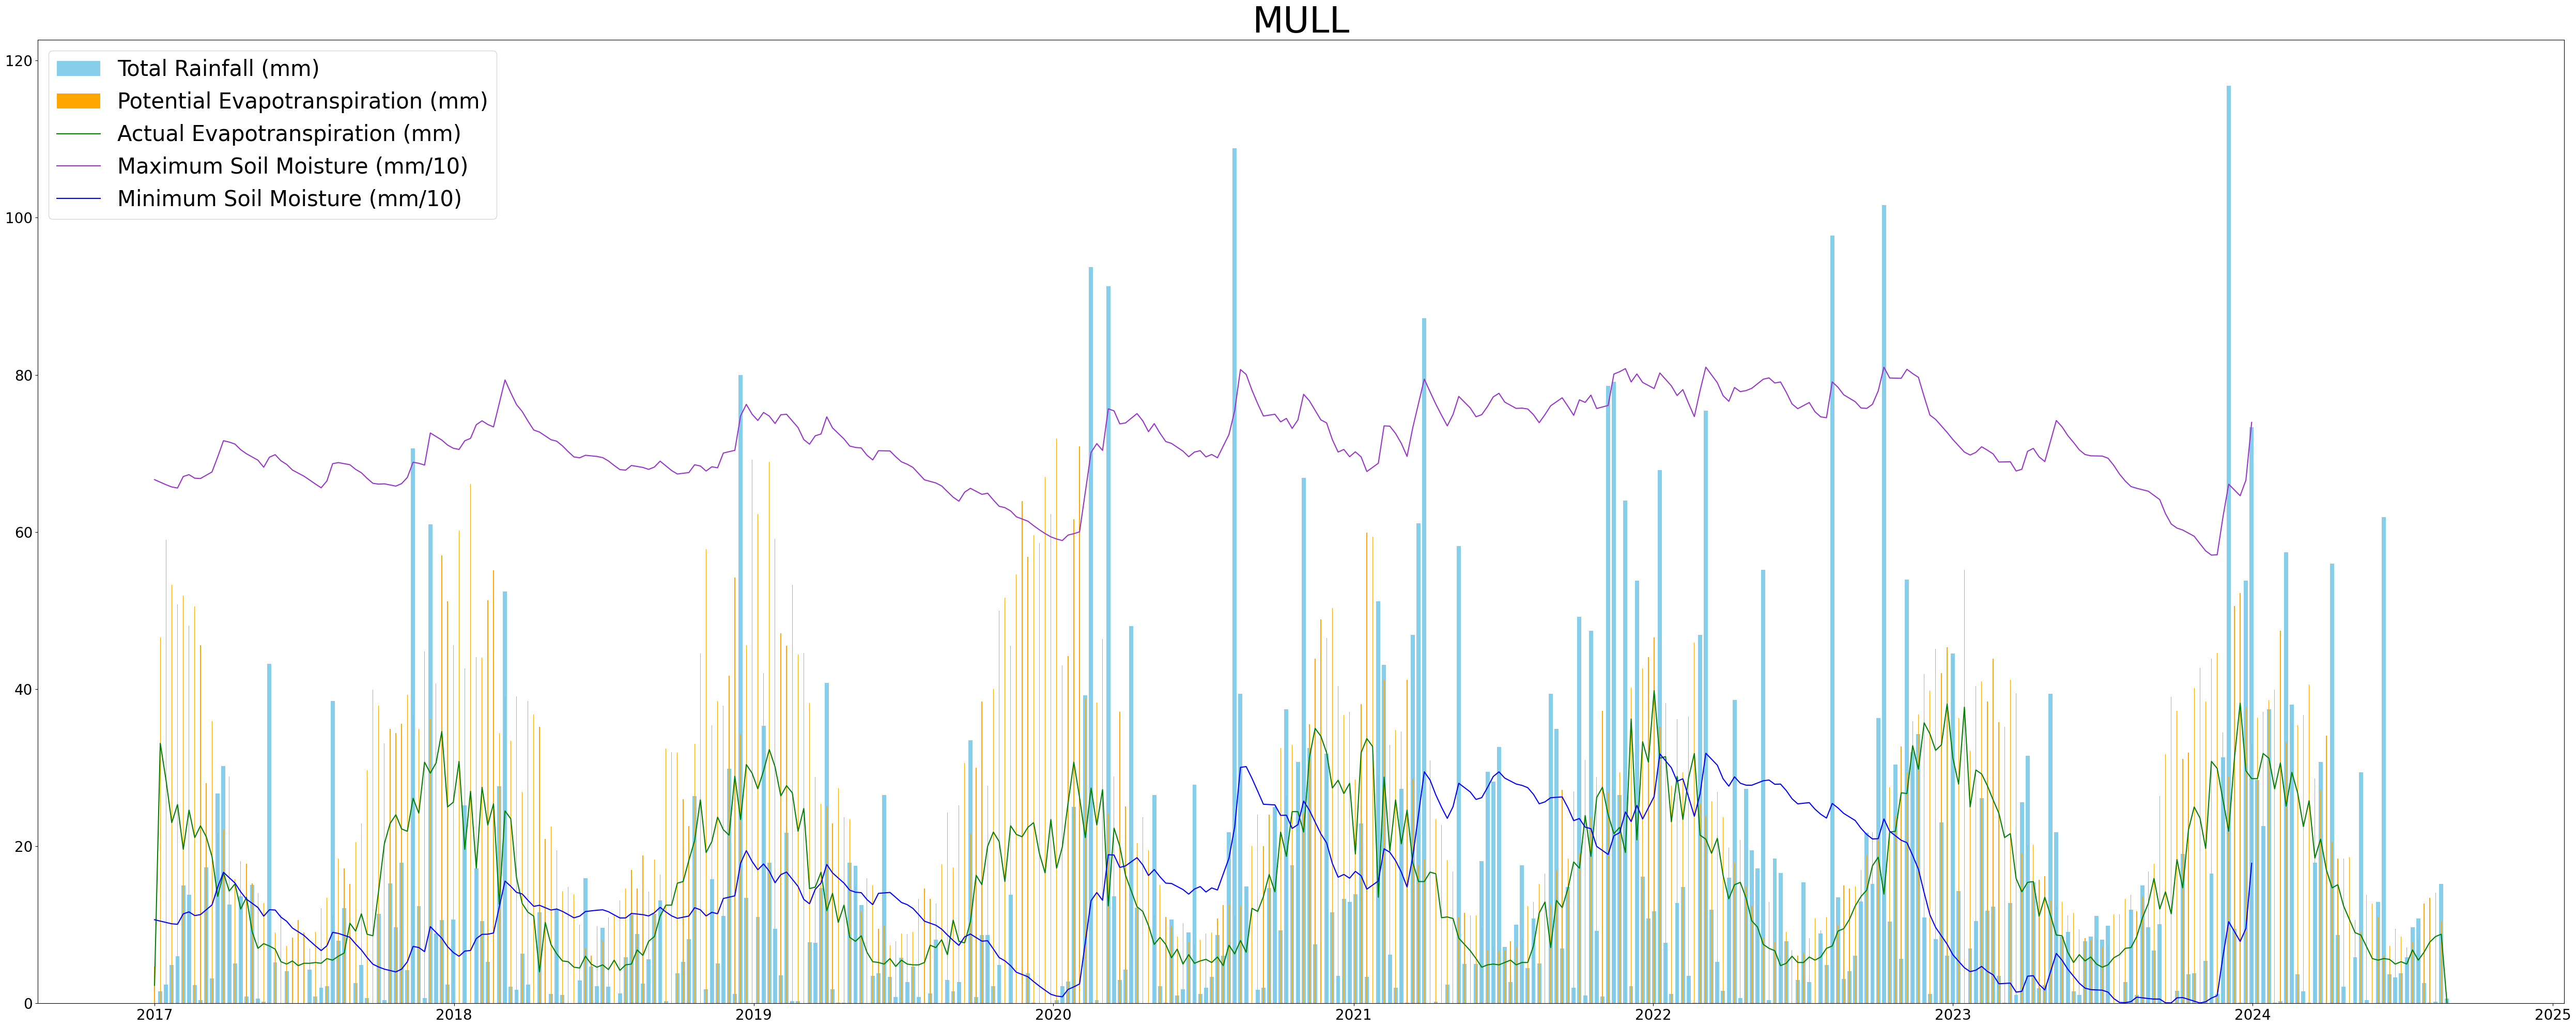

In [135]:
# Rainfall, evapotranspiration, soil moisture plot
plt.figure(figsize=(50, 20))

# Plot the data
rainfall_plot = plt.bar(weekly_df.index, weekly_df['Rainfall'], color='skyblue', width=5)
et_actual_plot = plt.bar(weekly_df.index, weekly_df['Potential Evapotranspiration'], color='orange')
et_potential_plot = plt.plot(weekly_df.index, weekly_df['Actual Evapotranspiration'], color='green')
moisture_max_plot = plt.plot(weekly_df.index, weekly_df['Maximum Soil Moisture']/10, color='darkorchid')
moisture_min_plot = plt.plot(weekly_df.index, weekly_df['Minimum Soil Moisture']/10, color='blue')

# Adjust the size of the tick labels on the x-axis and y-axis
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  

# Reorder the legend items
handles = [rainfall_plot, et_actual_plot[0], et_potential_plot[0], moisture_max_plot[0], moisture_min_plot[0]]
labels = ['Total Rainfall (mm)', "Potential Evapotranspiration (mm)", "Actual Evapotranspiration (mm)", "Maximum Soil Moisture (mm/10)", "Minimum Soil Moisture (mm/10)"]
plt.legend(handles=handles, labels=labels, fontsize=30, loc='upper left')
plt.title(f'{stub}', fontsize=50)

plt.tight_layout()

filename = os.path.join(visuals_dir, f"{stub}_weather.png")
plt.savefig(filename)
print(filename)

/scratch/xe2/cb8590/Visuals/MULL_temperature.png


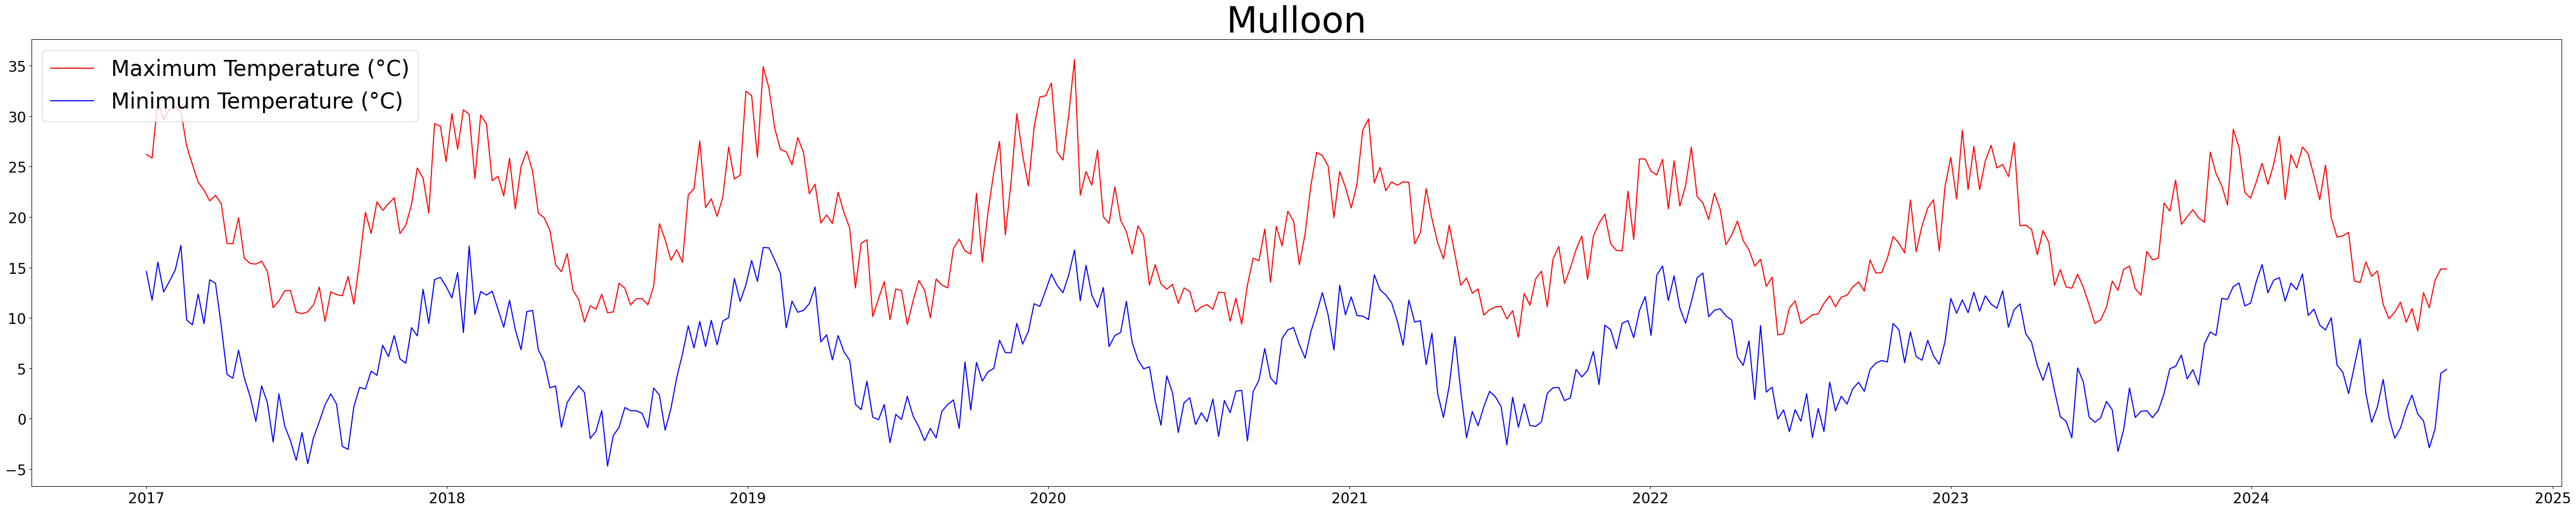

In [136]:
# Temperature plot
plt.figure(figsize=(50, 10))
maxtemp_plot = plt.plot(weekly_df.index, weekly_df["Maximum temperature"], color='red')
mintemp_plot = plt.plot(weekly_df.index, weekly_df["Minimum temperature"], color='blue')
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
handles = [maxtemp_plot[0], mintemp_plot[0]]
labels = ['Maximum Temperature (°C)', 'Minimum Temperature (°C)']
plt.legend(handles=handles, labels=labels, fontsize=30, loc='upper left')
plt.title(f'{stubs[stub]}', fontsize=50)
plt.tight_layout()

filename = os.path.join(visuals_dir, f"{stub}_temperature.png")
plt.savefig(filename)
print(filename)

In [57]:
for stub in stubs:
    # Load the sand, silt and clay layers
    filename_sand = os.path.join(outdir, f"{stub}_Sand.tif")
    filename_silt = os.path.join(outdir, f"{stub}_Silt.tif")
    filename_clay = os.path.join(outdir, f"{stub}_Clay.tif")
                            
    ds_sand = rxr.open_rasterio(filename_sand)
    ds_silt = rxr.open_rasterio(filename_silt)
    ds_clay = rxr.open_rasterio(filename_clay)
    
    sand_array = ds_sand.isel(band=0).values
    silt_array = ds_silt.isel(band=0).values
    clay_array = ds_clay.isel(band=0).values
    
    # Rescale values to add up to 100 (range was 74%-108% in Mullon example)
    total_percent = sand_array + silt_array + clay_array
    sand_percent = (sand_array / total_percent) * 100
    silt_percent = (silt_array / total_percent) * 100
    clay_percent = (clay_array / total_percent) * 100
    
    # Assign soil texture categories
    soil_texture = np.empty(sand_array.shape, dtype=object)
    soil_texture[(clay_array < 30) & (silt_array >= 50)] = 'Silt Loam'     # Silt Loam needs to come before Silt
    soil_texture[(clay_array < 15) & (silt_array >= 80)] = 'Silt'
    soil_texture[(clay_array >= 27) & (clay_array < 40) & (sand_array < 20)] = 'Silty Clay Loam'
    soil_texture[(clay_array >= 40) & (silt_array >= 40)] = 'Silty Clay'
    soil_texture[(clay_array >= 40) & (silt_array < 40) & (sand_array < 45)] = 'Clay'
    soil_texture[(clay_array >= 35) & (sand_array >= 45)] = 'Sandy Clay'
    soil_texture[(clay_array >= 27) & (clay_array < 40) & (sand_array >= 20) & (sand_array < 45) ] = 'Clay Loam'
    soil_texture[(clay_array >= 20) & (clay_array < 35) & (sand_array >= 45) & (silt_array < 28)] = 'Sandy Clay Loam'
    soil_texture[(clay_array < 20) & (silt_array < 50)] = 'Sandy Loam'      # Sandy Loam needs to come before Loam
    soil_texture[(clay_array >= 15) & (clay_array < 27) & (silt_array >= 28) & (silt_array < 50) & (sand_array < 53)] = 'Loam'
    
    # Fudged the boundaries between sand, loamy sand, and sandy loam, but the rest of these values match the soil texture triangle exactly
    soil_texture[(sand_array >= 75) & (clay_array < 15)] = 'Loamy Sand'
    soil_texture[(sand_array >= 85) & (clay_array < 10)] = 'Sand'
    
    print(np.unique(soil_texture))

['Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Clay' 'Clay Loam' 'Sandy Clay' 'Sandy Clay Loam' 'Sandy Loam']
